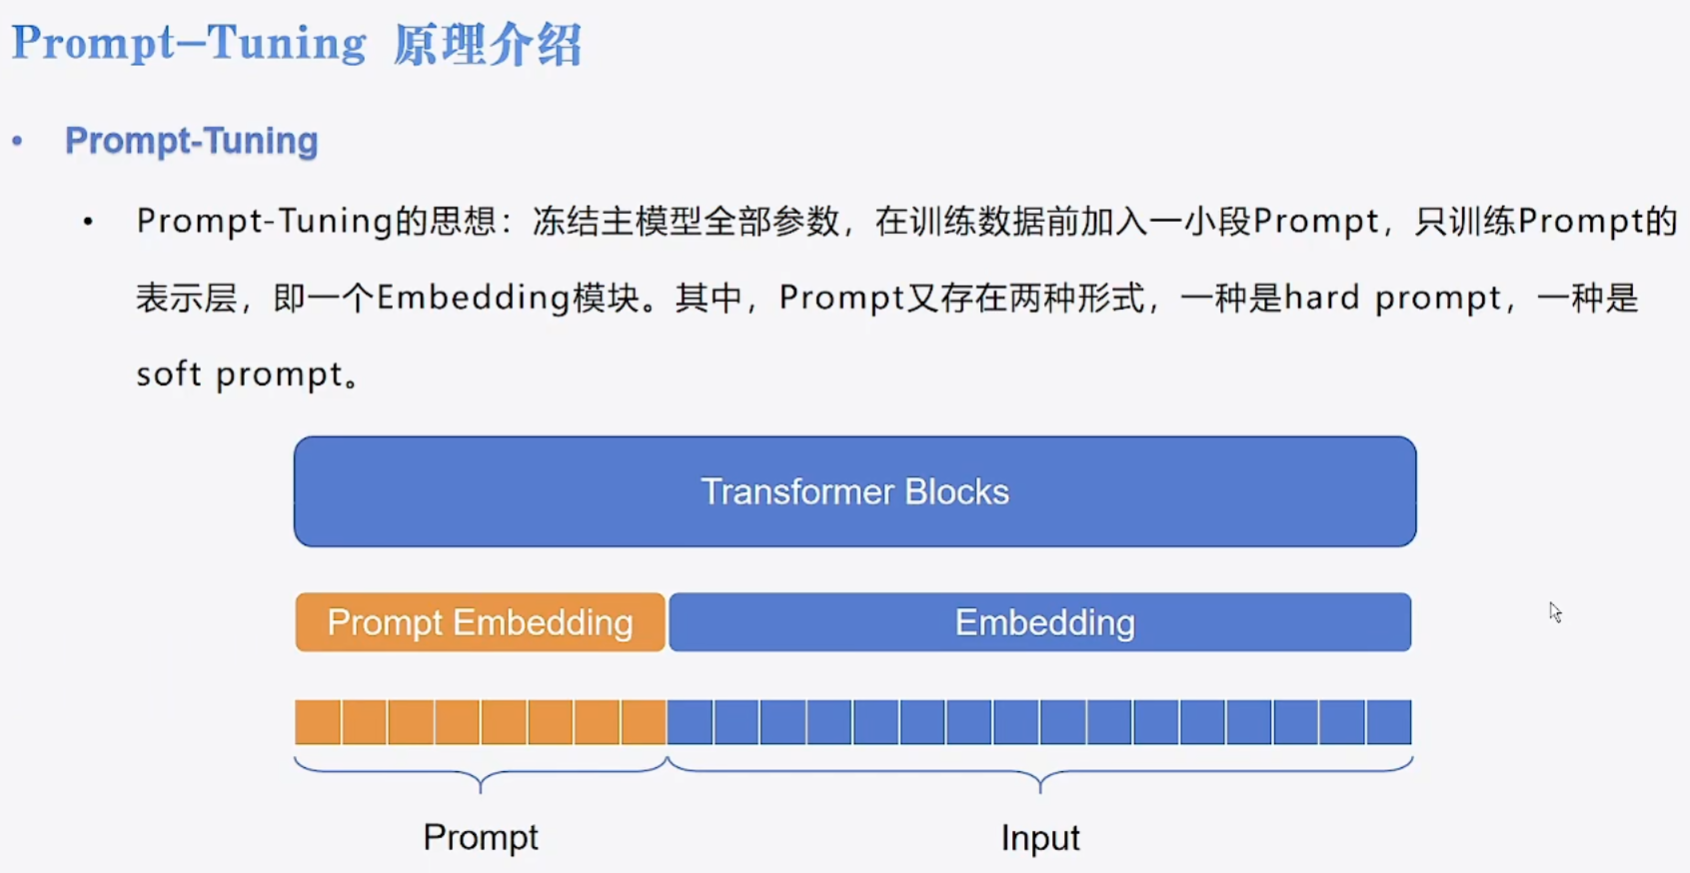

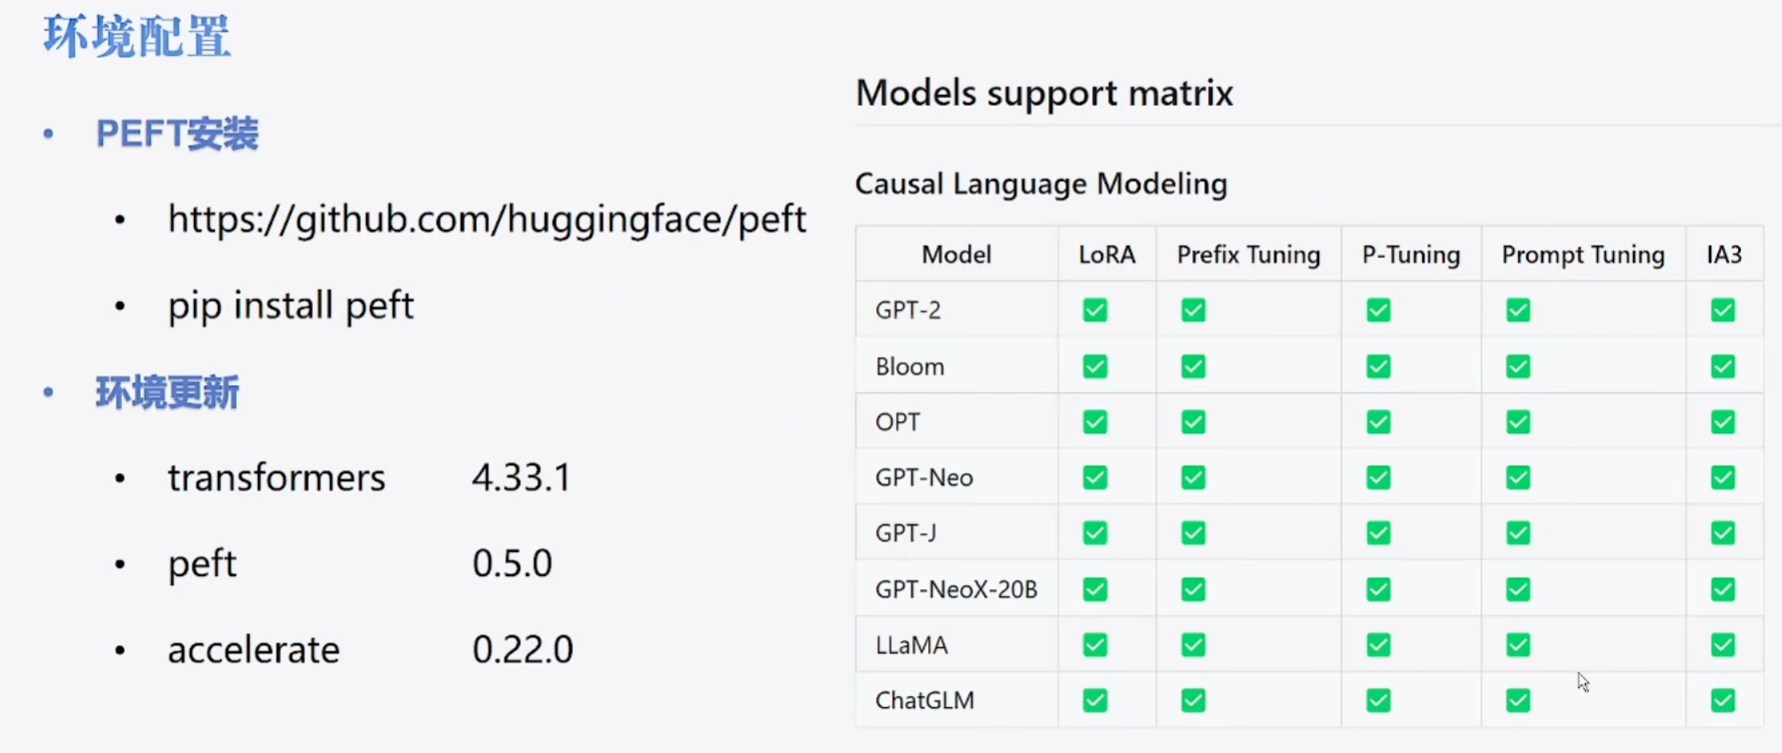

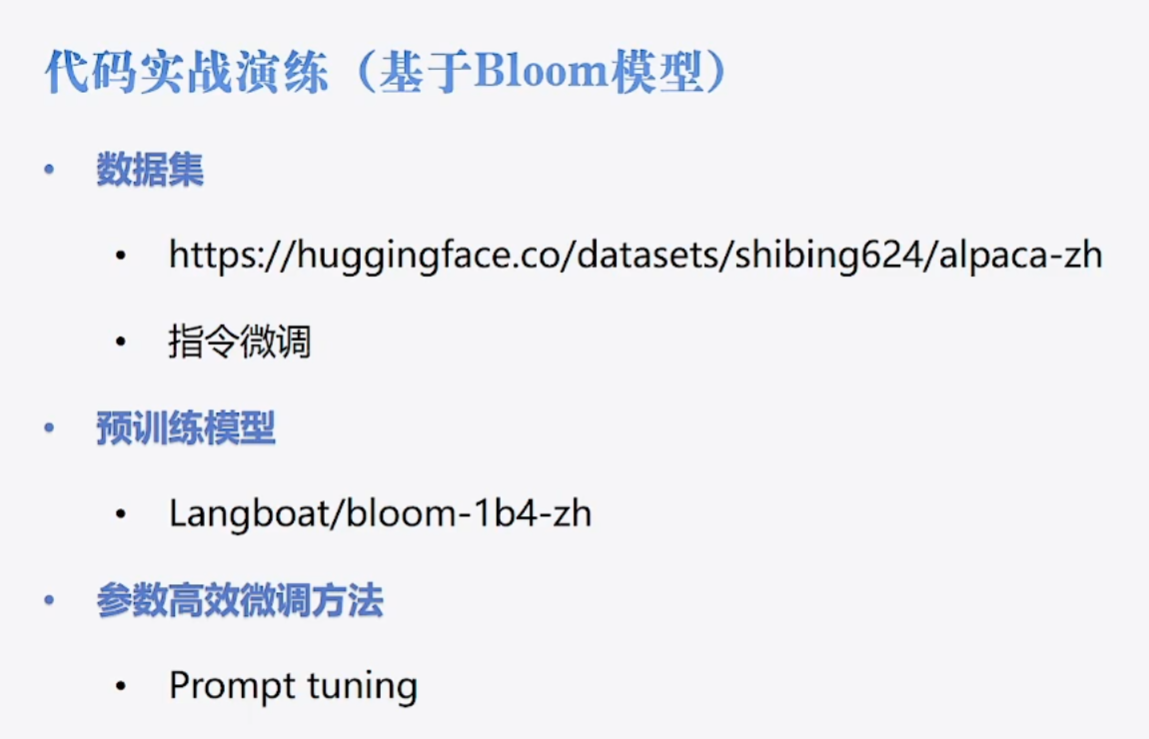

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [2]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [6]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True)

## Prompt Tuning

### Step1 配置文件

In [7]:
from peft import PromptTuningConfig,get_peft_model,TaskType,PromptTuningInit 
# PromptTuningConfig：用于配置提示微调（Prompt Tuning）相关参数。比如可以设置提示向量的长度、提示的初始化方式、任务类型等。通过这些参数的设置，可以灵活地定义如何在预训练模型中引入可训练的提示向量，以适应不同的下游任务需求。
# get_peft_model：用于获取带有提示微调功能的模型。该函数接受一个预训练模型和一个提示微调配置作为输入，返回一个带有提示微调功能的模型。通过该函数，可以方便地将预训练模型与提示微调功能结合在一起，实现模型的微调。
# TaskType：用于定义提示微调任务的类型。比如可以设置任务类型为“SEQ_2_SEQ_LM”（序列到序列语言模型），表示提示微调任务为序列到序列的文本生成任务。通过这些任务类型，可以方便地定义提示微调任务的类型，以适应不同的下游任务需求。
# PromptTuningInit：用于定义提示向量的初始化方式。比如可以设置初始化方式为“TEXT”，表示提示向量初始化为文本形式的向量。通过这些初始化方式，可以方便地定义提示向量的初始化方式，以适应不同的下游任务需求。

In [8]:
#------------------------------------------------ Soft prompt----------------------------------------------
# task_type是枚举类型，可选值有：TaskType.CAUSAL_LM, TaskType.SEQ_2_SEQ_LM, TaskType.SEQ_CLS, TaskType.TOKEN_
# num_virtual_tokens是提示向量的数量，默认为10。
# config=PromptTuningConfig(task_type=TaskType.CAUSAL_LM,num_virtual_tokens=10)
# config

#------------------------------------------------ Hard prompt----------------------------------------------
# prompt_tuning_init是枚举类型，可选值有：PromptTuningInit.RANDOM, PromptTuningInit.TEXT。
# PromptTuningInit.TEXT表示使用文本初始化提示向量。PromptTuningInit.RANDOM表示使用随机初始化提示向量。
# prompt_tuning_init_text是初始化提示向量的文本，默认为空字符串。
# tokenizer_name_or_path是分词器的名称或路径，默认为空字符串。

config=PromptTuningConfig(task_type=TaskType.CAUSAL_LM,
                          prompt_tuning_init=PromptTuningInit.TEXT,
                          prompt_tuning_init_text='下面是一段对话机器人的对话。',
                          num_virtual_tokens=len(tokenizer("下面是一段对话机器人的对话。")["input_ids"]),
                          tokenizer_name_or_path="Langboat/bloom-1b4-zh")
config

PromptTuningConfig(peft_type=<PeftType.PROMPT_TUNING: 'PROMPT_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=8, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, prompt_tuning_init=<PromptTuningInit.TEXT: 'TEXT'>, prompt_tuning_init_text='下面是一段对话机器人的对话。', tokenizer_name_or_path='Langboat/bloom-1b4-zh', tokenizer_kwargs=None)

### Step2 创建模型

In [9]:
model=get_peft_model(model,config)
model

PeftModelForCausalLM(
  (base_model): BloomForCausalLM(
    (transformer): BloomModel(
      (word_embeddings): Embedding(46145, 2048)
      (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (h): ModuleList(
        (0-23): 24 x BloomBlock(
          (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (self_attention): BloomAttention(
            (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
            (dense): Linear(in_features=2048, out_features=2048, bias=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
          )
          (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (mlp): BloomMLP(
            (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
            (gelu_impl): BloomGelu()
            (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          )
        )
      )

In [10]:
model.print_trainable_parameters()

trainable params: 16,384 || all params: 1,303,128,064 || trainable%: 0.0013


-------------------------------


In [11]:
args = TrainingArguments(
    output_dir="./promprt_tuning_hard",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [12]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

In [13]:
trainer.train()

  0%|          | 0/3357 [00:00<?, ?it/s]

{'loss': 2.94, 'grad_norm': 1.9316178560256958, 'learning_rate': 4.985105749180816e-05, 'epoch': 0.0}
{'loss': 3.115, 'grad_norm': 1.4972368478775024, 'learning_rate': 4.9702114983616324e-05, 'epoch': 0.01}
{'loss': 2.9347, 'grad_norm': 0.9889994859695435, 'learning_rate': 4.9553172475424484e-05, 'epoch': 0.01}
{'loss': 2.9221, 'grad_norm': 1.604330062866211, 'learning_rate': 4.940422996723265e-05, 'epoch': 0.01}
{'loss': 2.9526, 'grad_norm': 1.5233542919158936, 'learning_rate': 4.925528745904081e-05, 'epoch': 0.01}
{'loss': 2.9924, 'grad_norm': 1.2759381532669067, 'learning_rate': 4.910634495084897e-05, 'epoch': 0.02}
{'loss': 2.7867, 'grad_norm': 2.3074402809143066, 'learning_rate': 4.895740244265713e-05, 'epoch': 0.02}
{'loss': 2.7076, 'grad_norm': 1.2363717555999756, 'learning_rate': 4.88084599344653e-05, 'epoch': 0.02}
{'loss': 2.7087, 'grad_norm': 2.720015525817871, 'learning_rate': 4.865951742627346e-05, 'epoch': 0.03}
{'loss': 2.6011, 'grad_norm': 1.2326939105987549, 'learning_

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.4637, 'grad_norm': 7.526063442230225, 'learning_rate': 3.495680667262437e-05, 'epoch': 0.3}
{'loss': 2.466, 'grad_norm': 4.404968738555908, 'learning_rate': 3.480786416443253e-05, 'epoch': 0.3}
{'loss': 2.5258, 'grad_norm': 6.154778957366943, 'learning_rate': 3.465892165624069e-05, 'epoch': 0.31}
{'loss': 2.5325, 'grad_norm': 6.007318019866943, 'learning_rate': 3.450997914804885e-05, 'epoch': 0.31}
{'loss': 2.428, 'grad_norm': 10.316154479980469, 'learning_rate': 3.436103663985702e-05, 'epoch': 0.31}
{'loss': 2.5236, 'grad_norm': 4.5936408042907715, 'learning_rate': 3.421209413166518e-05, 'epoch': 0.32}
{'loss': 2.4992, 'grad_norm': 17.086790084838867, 'learning_rate': 3.406315162347334e-05, 'epoch': 0.32}
{'loss': 2.6034, 'grad_norm': 5.593808650970459, 'learning_rate': 3.39142091152815e-05, 'epoch': 0.32}
{'loss': 2.4182, 'grad_norm': 8.038372039794922, 'learning_rate': 3.376526660708966e-05, 'epoch': 0.32}
{'loss': 2.3983, 'grad_norm': 7.674581050872803, 'learning_rate': 

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.5162, 'grad_norm': 4.483537673950195, 'learning_rate': 2.750968126303247e-05, 'epoch': 0.45}
{'loss': 2.4184, 'grad_norm': 6.8921661376953125, 'learning_rate': 2.7360738754840632e-05, 'epoch': 0.45}
{'loss': 2.5929, 'grad_norm': 3.0486929416656494, 'learning_rate': 2.7211796246648796e-05, 'epoch': 0.46}
{'loss': 2.4875, 'grad_norm': 4.460941314697266, 'learning_rate': 2.7062853738456957e-05, 'epoch': 0.46}
{'loss': 2.5922, 'grad_norm': 6.5229387283325195, 'learning_rate': 2.691391123026512e-05, 'epoch': 0.46}
{'loss': 2.4379, 'grad_norm': 2.751915454864502, 'learning_rate': 2.676496872207328e-05, 'epoch': 0.46}
{'loss': 2.3866, 'grad_norm': 6.445446968078613, 'learning_rate': 2.6616026213881445e-05, 'epoch': 0.47}
{'loss': 2.2034, 'grad_norm': 3.6588289737701416, 'learning_rate': 2.6467083705689606e-05, 'epoch': 0.47}
{'loss': 2.4087, 'grad_norm': 2.9547832012176514, 'learning_rate': 2.631814119749777e-05, 'epoch': 0.47}
{'loss': 2.5426, 'grad_norm': 4.550505638122559, 'lear

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.4125, 'grad_norm': 8.836710929870605, 'learning_rate': 2.0062555853440572e-05, 'epoch': 0.6}
{'loss': 2.4035, 'grad_norm': 5.278441905975342, 'learning_rate': 1.9913613345248736e-05, 'epoch': 0.6}
{'loss': 2.4919, 'grad_norm': 5.270443439483643, 'learning_rate': 1.9764670837056897e-05, 'epoch': 0.6}
{'loss': 2.3637, 'grad_norm': 4.146263122558594, 'learning_rate': 1.961572832886506e-05, 'epoch': 0.61}
{'loss': 2.5408, 'grad_norm': 4.842425346374512, 'learning_rate': 1.946678582067322e-05, 'epoch': 0.61}
{'loss': 2.4155, 'grad_norm': 6.466989040374756, 'learning_rate': 1.9317843312481382e-05, 'epoch': 0.61}
{'loss': 2.3437, 'grad_norm': 4.757781505584717, 'learning_rate': 1.9168900804289542e-05, 'epoch': 0.62}
{'loss': 2.4313, 'grad_norm': 5.463369846343994, 'learning_rate': 1.9019958296097706e-05, 'epoch': 0.62}
{'loss': 2.3543, 'grad_norm': 6.821366786956787, 'learning_rate': 1.8871015787905867e-05, 'epoch': 0.62}
{'loss': 2.4228, 'grad_norm': 6.142660617828369, 'learning_r

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.3893, 'grad_norm': 18.39838981628418, 'learning_rate': 1.2615430443848674e-05, 'epoch': 0.75}
{'loss': 2.4162, 'grad_norm': 10.499990463256836, 'learning_rate': 1.2466487935656837e-05, 'epoch': 0.75}
{'loss': 2.4824, 'grad_norm': 6.915414810180664, 'learning_rate': 1.2317545427464999e-05, 'epoch': 0.75}
{'loss': 2.4742, 'grad_norm': 5.53245210647583, 'learning_rate': 1.2168602919273161e-05, 'epoch': 0.76}
{'loss': 2.4507, 'grad_norm': 6.617571830749512, 'learning_rate': 1.2019660411081324e-05, 'epoch': 0.76}
{'loss': 2.4084, 'grad_norm': 3.450805902481079, 'learning_rate': 1.1870717902889484e-05, 'epoch': 0.76}
{'loss': 2.4337, 'grad_norm': 20.692739486694336, 'learning_rate': 1.1721775394697646e-05, 'epoch': 0.77}
{'loss': 2.5616, 'grad_norm': 4.89466667175293, 'learning_rate': 1.1572832886505809e-05, 'epoch': 0.77}
{'loss': 2.5837, 'grad_norm': 13.694751739501953, 'learning_rate': 1.1423890378313971e-05, 'epoch': 0.77}
{'loss': 2.5054, 'grad_norm': 7.477034091949463, 'lear

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'loss': 2.3971, 'grad_norm': 4.51210880279541, 'learning_rate': 5.168305034256777e-06, 'epoch': 0.9}
{'loss': 2.4908, 'grad_norm': 9.025842666625977, 'learning_rate': 5.019362526064939e-06, 'epoch': 0.9}
{'loss': 2.5169, 'grad_norm': 9.12224292755127, 'learning_rate': 4.870420017873101e-06, 'epoch': 0.9}
{'loss': 2.3578, 'grad_norm': 6.535168647766113, 'learning_rate': 4.721477509681263e-06, 'epoch': 0.91}
{'loss': 2.5227, 'grad_norm': 4.709076881408691, 'learning_rate': 4.572535001489425e-06, 'epoch': 0.91}
{'loss': 2.4362, 'grad_norm': 6.117351531982422, 'learning_rate': 4.423592493297587e-06, 'epoch': 0.91}
{'loss': 2.5507, 'grad_norm': 4.425958156585693, 'learning_rate': 4.274649985105749e-06, 'epoch': 0.91}
{'loss': 2.4921, 'grad_norm': 4.832925796508789, 'learning_rate': 4.125707476913911e-06, 'epoch': 0.92}
{'loss': 2.5713, 'grad_norm': 5.4165940284729, 'learning_rate': 3.976764968722073e-06, 'epoch': 0.92}
{'loss': 2.368, 'grad_norm': 7.603847503662109, 'learning_rate': 3.8278

TrainOutput(global_step=3357, training_loss=2.5054742121646756, metrics={'train_runtime': 2966.8891, 'train_samples_per_second': 9.053, 'train_steps_per_second': 1.131, 'total_flos': 1.476411489067008e+16, 'train_loss': 2.5054742121646756, 'epoch': 0.9999255342914588})

In [14]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 在面对一道考试题，需要掌握哪些技巧？回答此问题时要先了解考试的目的，弄清楚考试的目的是达到学习目的还是测试目的，如果是测试目的是，则需要通过答案来了解所考查的知识。以下是一些与考试目的相关的技巧：

1. 思考技巧

考生在考场上必须利用各种方法和技巧来思考，比如：分析图表、思考关键词、利用知识库、利用模板、模拟练习、通过阅读和阅读后的思考等等。这些方法和技巧可以提高考生思考的准确性，还可以提高


## 加载训练好的PEFT模型

In [15]:
from peft import PeftModel


In [16]:
peft_model = PeftModel.from_pretrained(model, "./promprt_tuning_hard/checkpoint-500")
peft_model

PeftModelForCausalLM(
  (base_model): PeftModelForCausalLM(
    (base_model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(46145, 2048)
        (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (mlp): BloomMLP(
              (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
              (gelu_impl): BloomGelu()
              (dense_4h_to_h): Linear(in_fe

In [17]:
peft_model = peft_model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True))

Human: 考试有哪些技巧？

Assistant: 技巧主要有以下几个方面：
语言表达方面：
语言表达要简洁、精练、清楚易懂。尤其是词汇的量不要太大，能简单表述清楚即可。而且应该避免使用重复词语。结构方面：
结构要清晰、完整，要有总结和概括的能力。要尽量使用短句，避免用长句。文章的章与节间不要有生僻、拗口的、过于长、过于短的句子。写作速度、字数方面要保持一致、稳定。文体方面：
文章以记叙文为主，并兼有
